In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
import pymc3 as pm
palette = 'muted'
sns.set_palette(palette); sns.set_color_codes(palette)
sns.set()

# ガウシアン推定

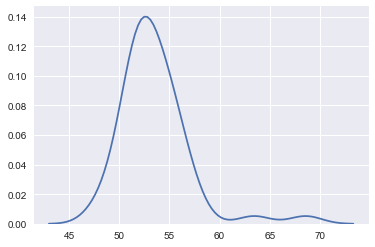

In [11]:
# Gauss分布に従うと想定される実験結果

data = np.array([51.06, 55.12, 53.73, 50.24, 52.05, 56.40, 48.45, 52.34, 55.65, 51.49, 51.86, 63.43, 53.00, 56.09, 51.93, 52.31, 52.33, 57.48, 57.44, 55.14, 53.93, 54.62, 56.09, 68.58, 51.36, 55.47, 50.73, 51.94, 54.95, 50.39, 52.91, 51.5, 52.68, 47.72, 49.73, 51.82, 54.99, 52.84, 53.19, 54.52, 51.46, 53.73, 51.61, 49.81, 52.42, 54.3, 53.84, 53.16])

sns.kdeplot(data)

## 母平均と母分散を推定する

In [12]:
with pm.Model() as model_g:
    mu=pm.Uniform('mu',lower=40,upper=70) # upperとlowerの間にあると仮定
    sigma=pm.HalfNormal('sigma',sd=10) # 半正規分布を仮定
    
    # 事後分布のモデルを構築
    y=pm.Normal('y',mu=mu,sd=sigma,observed=data)
    start=pm.find_MAP()
    trace_g=pm.sample(1100,start=start)

logp = -155.3, ||grad|| = 39.05: 100%|██████████| 9/9 [00:00<00:00, 1166.89it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains: 100%|██████████| 6400/6400 [00:02<00:00, 3126.26draws/s]
The acceptance probability does not match the target. It is 0.8804462196731525, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1188c7be0>,
      dtype=object)

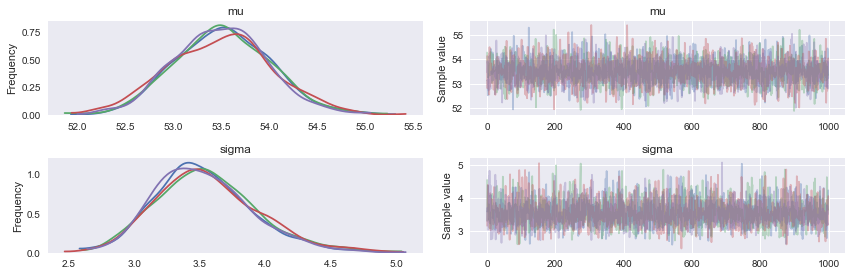

In [13]:
chain_g=trace_g[100:]
pm.traceplot(chain_g)

In [14]:
pm.summary(chain_g)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,53.499751,0.510483,0.007738,52.525363,54.516869,3964.454950,1.000205
sigma,3.542809,0.381279,0.006709,2.857027,4.323814,3698.422631,1.000785


array([<matplotlib.axes._subplots.AxesSubplot object at 0x10dcd14a8>,
      dtype=object)

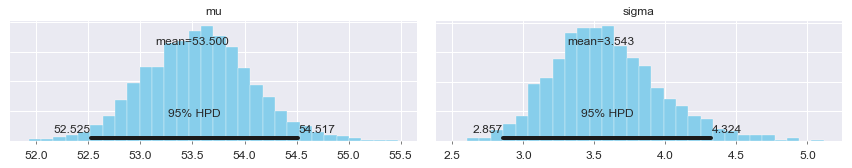

In [15]:
pm.plot_posterior(chain_g)

## 事後分布から、100組の予測値を導出

100%|██████████| 100/100 [00:00<00:00, 1023.64it/s]
/Users/hiroaki/.pyenv/versions/3.6.5/envs/pycoon365/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


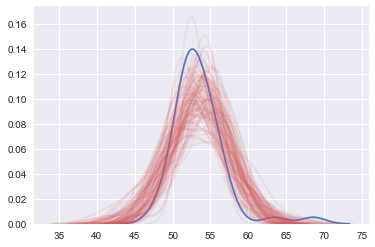

In [36]:
y_pred=pm.sample_ppc(chain_g,100,model_g,size=len(data))
sns.kdeplot(data,c='b')
for i in y_pred['y']:
    sns.kdeplot(i[0],c='r',alpha=0.1)

# student-t

## 分布

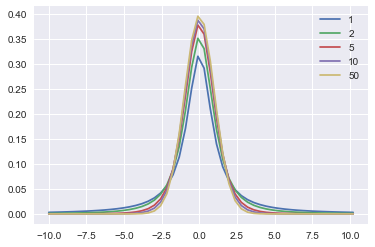

In [17]:
x_value=np.linspace(-10,10.200)

# どれ位ガウス分布に似ているかを表す
norm_values=[1,2,5,10,50]
for norm in norm_values:
    dist=stats.t(norm)
    x_pdf=dist.pdf(x_value)
    plt.plot(x_value,x_pdf,label=norm)
plt.legend()

## 右側の広がりを再現するため、尤度をt分布に置き換える

In [38]:
with pm.Model() as model_t:
    mu=pm.Uniform('mu',40,75)
    sigma=pm.HalfNormal('sigma',sd=10)
    nu=pm.Exponential('nu',1/30)
    y=pm.StudentT('y',mu=mu,sd=sigma,nu=nu,observed=data)
    
    trace_t=pm.sample(1100,njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, mu]
Sampling 4 chains: 100%|██████████| 6400/6400 [00:02<00:00, 2252.98draws/s]


## 可視化

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c882f98>,
      dtype=object)

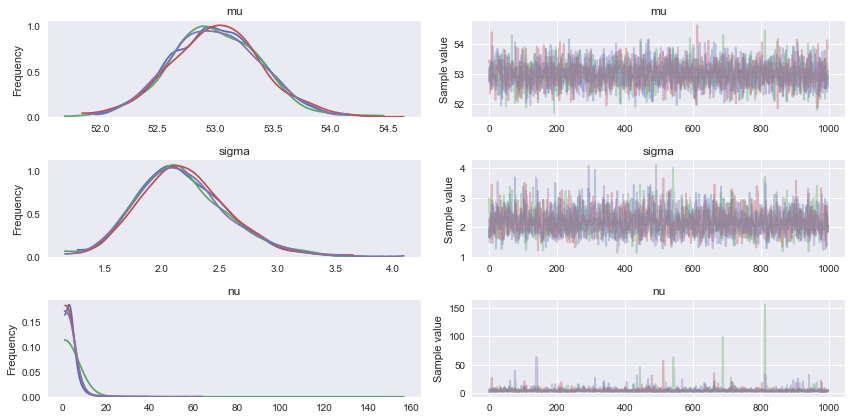

In [39]:
chain_t=trace_t[100:]
pm.traceplot(chain_t)

In [40]:
pm.summary(chain_t)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,52.998652,0.395122,0.008013,52.251753,53.816920,2555.929566,0.999744
sigma,2.181371,0.395903,0.008269,1.473794,2.980820,2279.118945,0.999923
nu,4.642525,5.115547,0.122436,1.183914,9.783277,1636.277723,0.999843


array([<matplotlib.axes._subplots.AxesSubplot object at 0x118736a90>,
      dtype=object)

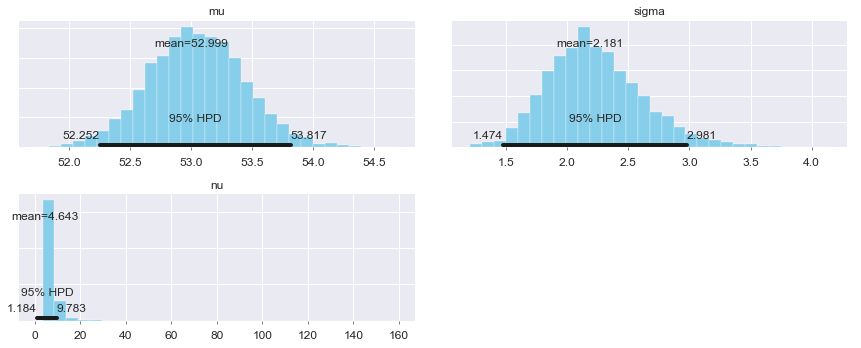

In [41]:
pm.plot_posterior(chain_t)

## 予測分布

100%|██████████| 100/100 [00:00<00:00, 787.64it/s]


(25, 100)

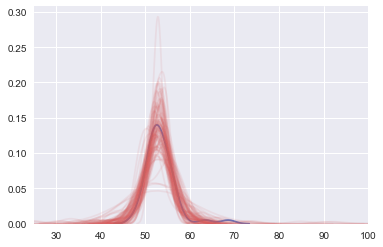

In [43]:
y_pred=pm.sample_ppc(chain_t,100,model_t,size=len(data))
sns.kdeplot(data,color='b')
for i in y_pred['y']:
    sns.kdeplot(i[0],color='r',alpha=0.1)
plt.xlim([25,100])

ロバストなモデルになっている